## Imports and Setup

In [1]:
!pip install textblob

import pandas as pd
import numpy as np
import sklearn
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import textblob
#from wordcloud import WordCloud
from pathlib import Path
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score

import pickle
import re
import time
import datetime                              # access to %%time, for timing individual notebook cells
import os
from PIL import Image
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Use 'seaborn-v0_8' instead of 'seaborn'
plt.style.use('seaborn-v0_8')  # This line is changed to use a valid seaborn style
plt.rcParams["figure.figsize"] = (15,10)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

# Define file path
file_path = "/content/drive/MyDrive/ITS RESEARCH/HALAL_ITS/DATASET/RGBI/moneyspent_cleaned.xlsx"

# Read the Excel file
df_review_moneyspent = pd.read_excel(file_path)

# Display the first few rows
df_review_moneyspent.head()


,no,money_spent,username,umkm,review,batas_bawah,batas_atas,median,rating
0,1,0-25000,Ilungg,Bakso Eko,tidak ada transcript,0,25000,12500,5
1,2,0-25000,Fareldanendraa,Bakso Eko,baksonya enak,0,25000,12500,5
2,3,0-25000,irfanalmizan,Bakso Eko,baksonya enak abis,0,25000,12500,5
3,4,0-25000,ryanadiputrapratama,Bakso Eko,tidak ada transcript,0,25000,12500,5
4,5,0-25000,dwmhr,Bakso Eko,baksonya sangat enak,0,25000,12500,5


In [4]:
df_review_moneyspent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   no           72 non-null     int64 
 1   money_spent  72 non-null     object
 2   username     72 non-null     object
 3   umkm         72 non-null     object
 4   review       72 non-null     object
 5   batas_bawah  72 non-null     int64 
 6   batas_atas   72 non-null     int64 
 7   median       72 non-null     int64 
 8   rating       72 non-null     int64 
dtypes: int64(5), object(4)
memory usage: 5.2+ KB


In [5]:
print(df_review_moneyspent.umkm.unique())
print(df_review_moneyspent.username.unique())
print("Lapak yang dilakukan review ada sebanyak: ", df_review_moneyspent.umkm.nunique())
print("User yang melakukan review ada sebanyak: ", df_review_moneyspent.username.nunique())

['Bakso Eko' 'Bakso Pak Parlin' 'Drink House'
 'Mak Nun (Kafetaria Informatika)' 'Pempek Berlian' 'Pentol Petarung'
 'Sego Njamoer' 'Tahu Tek dan Lontong Cak Aris'
 'Warung Bu Sol (Kafetaria Informatika)' 'Es Coklat Mantap'
 'NLH Snack Ringan' 'Diva Cookies' 'Kedai Minuman Asrama'
 'Kantin Asrama Bu Geprek' 'Sambelan Cak Dayat'
 'Kress Nyuss Fried Chicken' 'Bebek Goreng Mesra Surabaya'
 'Waroeng Anggrek']
['Ilungg' 'Fareldanendraa' 'irfanalmizan' 'ryanadiputrapratama' 'dwmhr'
 'Annisafd3r' 'Laksono' 'afandiwirawan' 'Nabil_07' 'BerlianYafi' 'Alhaura'
 'Arkaan' 'rapiep' 'rfarelll' 'mfazms' 'abed1' 'zaidanfawwasz' 'chrsthper'
 'siskaaRif' 'abed' 'athallaabh' '5025221159' 'abimanyudans' 'Naruto'
 'Hans_IF23_034' 'itozt' 'diosacha' 'felda_ega' 'Daffa218_' 'rajen270_'
 'Rajasa' '_farfat' 'Anam' 'Ikannila' 'farrasariffadhila' 'Ezra'
 'aliyahpattoza' 'ferzenK' 'akmalbobsaid' '5025231057' 'joseph'
 'Eldintaro' 'nouvalryhn' 'feersdila' 'Rafif_thariq' 'Kolbi' 'AdityaIyan'
 'zafira271' 'Sirund']
L

In [6]:
df_review_moneyspent

,no,money_spent,username,umkm,review,batas_bawah,batas_atas,median,rating
0,1,0-25000,Ilungg,Bakso Eko,tidak ada transcript,0,25000,12500,5
1,2,0-25000,Fareldanendraa,Bakso Eko,baksonya enak,0,25000,12500,5
2,3,0-25000,irfanalmizan,Bakso Eko,baksonya enak abis,0,25000,12500,5
3,4,0-25000,ryanadiputrapratama,Bakso Eko,tidak ada transcript,0,25000,12500,5
4,5,0-25000,dwmhr,Bakso Eko,baksonya sangat enak,0,25000,12500,5
...,...,...,...,...,...,...,...,...,...
67,68,0-25000,rajen270_,Bakso Pak Parlin,sangat enak,0,25000,12500,5
68,69,0-25000,AdityaIyan,Bebek Goreng Mesra Surabaya,"Ya disini, masih dibuatin bebeknya, kemungkina...",0,25000,12500,4
69,70,0-25000,zafira271,Bebek Goreng Mesra Surabaya,jadi di sini saya pesan bebek,0,25000,12500,5
70,71,76000-100000,Sirund,Diva Cookies,pelayanan cepat dan ramah,76000,100000,88000,5


## Saving & Exporting

In [14]:
df_review_moneyspent.to_csv('out.csv', index=False)

In [15]:
!pip install emoji

import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", 200)
#from pandas_profiling import ProfileReport
from PIL import Image
import regex
import nltk
import wordcloud
import textblob

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

import string
import re
import emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 28.5 MB/s eta 0:00:00


In [16]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords

# Load Indonesian stopwords
indonesian_stopwords = set(stopwords.words('indonesian'))
print(indonesian_stopwords)

{'sekaligus', 'enggaknya', 'tandas', 'keluar', 'teringat', 'menanya', 'manakala', 'menaiki', 'terhadap', 'wahai', 'sepantasnya', 'hendaknya', 'berupa', 'lagi', 'bagaimanakah', 'tertentu', 'antaranya', 'tetapi', 'semampunya', 'mulailah', 'amat', 'memihak', 'macam', 'diibaratkannya', 'jawaban', 'serupa', 'yang', 'umum', 'bersama', 'dengan', 'justru', 'sesama', 'dibuatnya', 'sampaikan', 'dimaksudkan', 'betulkah', 'berikan', 'seolah-olah', 'seperti', 'berkata', 'ibaratkan', 'dilakukan', 'begini', 'seterusnya', 'cukuplah', 'mungkinkah', 'tandasnya', 'termasuk', 'ditunjukkan', 'sekiranya', 'mempunyai', 'jawab', 'sebegitu', 'misalnya', 'tertuju', 'harus', 'minta', 'ungkap', 'tanyanya', 'dibuat', 'manalagi', 'kemungkinan', 'sekali', 'terutama', 'bukan', 'kelamaan', 'masalahnya', 'sewaktu', 'begitukah', 'diakhirinya', 'nah', 'asalkan', 'aku', 'memang', 'usah', 'bakal', 'inginkan', 'tanpa', 'sekadarnya', 'belum', 'berkehendak', 'telah', 'selamanya', 'apalagi', 'demikian', 'berapa', 'lalu', 'seja

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
# Add custom stopwords
custom_stopwords = {'transcript', 'iya', 'harganya'}  # Example additional words
custom_stopwords2 = ["untuk", "sangat", "dan", "tidak", "haus", "aplikasi", "ini", "ada", "transcript", "5", "abis", "bentuk", "sekali", "dengan", "cukup", "sedikit", "tes", "nya", "Eko", "akan", "beri", "nilai", "tetapi", "aku", "sering", "iya", "cuma", "di", "yang", "saya", "banget", "sudah", "disini", "sini", "sepertinya", "masih", "juga", "tinggal"]

# Merge with existing stopwords
indonesian_stopwords.update(custom_stopwords)
indonesian_stopwords.update(custom_stopwords2)

print("Updated stopwords:", indonesian_stopwords)

Updated stopwords: {'sekaligus', 'enggaknya', 'tandas', 'keluar', 'teringat', 'menanya', 'manakala', 'menaiki', 'terhadap', 'wahai', 'sepantasnya', 'hendaknya', 'berupa', 'lagi', 'bagaimanakah', 'tertentu', 'antaranya', 'tetapi', 'semampunya', 'mulailah', 'amat', 'memihak', 'macam', 'diibaratkannya', 'jawaban', 'serupa', 'yang', 'umum', 'bersama', 'dengan', 'justru', 'sesama', 'dibuatnya', 'sampaikan', 'dimaksudkan', 'betulkah', 'berikan', 'seolah-olah', 'seperti', 'berkata', 'ibaratkan', 'aplikasi', 'dilakukan', 'begini', 'seterusnya', 'cukuplah', 'mungkinkah', 'tandasnya', 'termasuk', 'ditunjukkan', 'sekiranya', 'mempunyai', 'jawab', 'sebegitu', 'misalnya', 'tertuju', 'harus', 'minta', 'ungkap', 'tanyanya', 'dibuat', 'manalagi', 'kemungkinan', 'sekali', 'terutama', 'bukan', 'kelamaan', 'masalahnya', 'sewaktu', 'begitukah', 'diakhirinya', 'nah', 'asalkan', 'aku', 'memang', 'usah', 'bakal', 'inginkan', 'tanpa', 'sekadarnya', 'belum', 'berkehendak', 'telah', 'selamanya', 'apalagi', 'dem

In [18]:
len(indonesian_stopwords)

771

## Data Preprocessing

In [21]:
!pip install Sastrawi

import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')


# Create stemmer and lemmatizer objects
factory = StemmerFactory()
stemmer = factory.create_stemmer()
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Case lowering
    text = text.lower()

    # Punctuation removal
    text = re.sub(r'[^\w\s]', '', text)

    # Stemming
    text = stemmer.stem(text)

    # Lemmatization (requires a part-of-speech tag for optimal results, using 'v' for verb as a default)
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word, 'v') for word in words]
    text = ' '.join(lemmatized_words)

    return text

# Apply the cleaning function to the 'review' column
df_review_moneyspent['cleaned_review'] = df_review_moneyspent['review'].apply(clean_text)

# Display the DataFrame with the cleaned reviews
print(df_review_moneyspent[['review', 'cleaned_review']])


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


                                                                                                                                                                              review  \
0                                                                                                                                                               tidak ada transcript   
1                                                                                                                                                                      baksonya enak   
2                                                                                                                                                                 baksonya enak abis   
3                                                                                                                                                               tidak ada transcript   
4                                                                               

In [22]:
#Join seluruh user review dalam satu corpus
all_user_review = ' '.join(df_review_moneyspent['cleaned_review'])

In [23]:
def remove_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in indonesian_stopwords]
    return ' '.join(filtered_words)

clean_text = remove_stopwords(all_user_review)
print("Cleaned text:", clean_text)

Cleaned text: bakso enak bakso enak bakso enak mantap mantap scan bakso rekomendasi laku bakso enak harga mahal enak bakso bakso eko enak bakso enak kenyal bakso eko mantap halal siar minum seger enak minum enak manis spk muka murah layan cepat minum enak minum segar hilang minum layar bagus minum enak pas mantap segar enak murah segar enak segar murah jalan aman seger mantap seger mantap enak minum dingindingin enak makan enak gizi sehat lezat murah foto enak makan enak rekomen nice enak makan enak hargaharga murah enak bikin kenyang bakso enak harga murah jangkau tonton oke keren makan enakenak sesuai foto nampak sepi lengkap foto toko suka minum segar minum enak bangga beli minum tugas ktpel enak bakso enak rebut ya enak enak enak lumayan enak sih harga murah makan pergi rupa lapak kenal laku jumat tanggal 15 november 2022 8 dagang laku sisa 2 12 potong ayam ulas enak lokasi 7 930 lokasi sulit jangkau makan mes nasi goreng 6 10 pokok mantap enak minum segar enak restoran jual nasi a

In [24]:
all_user_review = clean_text

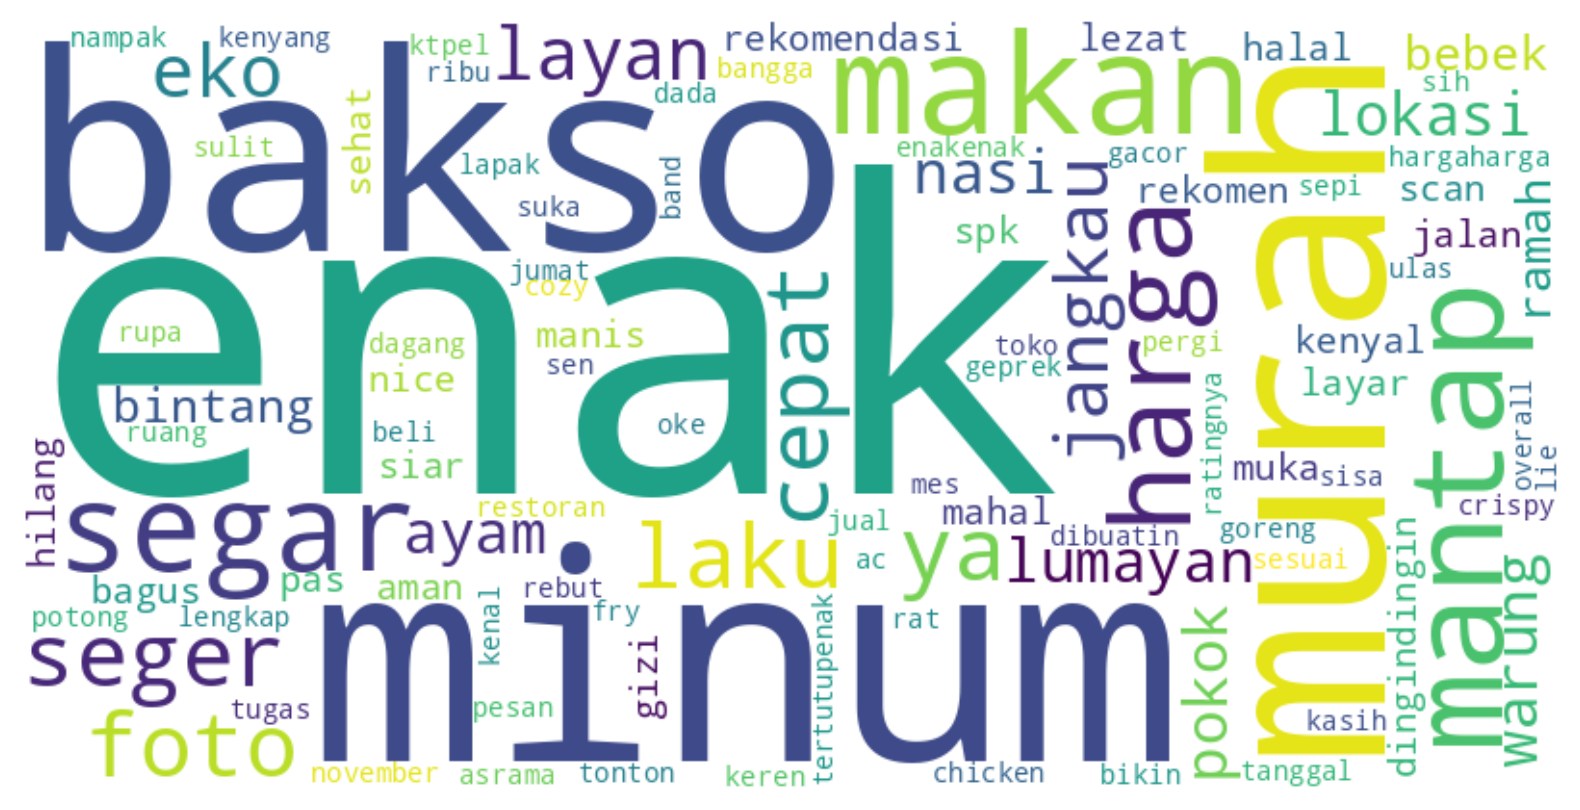

In [25]:
# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_user_review)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")  # Hide axis
plt.show()

In [26]:
halal_mask = np.array(Image.open('/content/drive/MyDrive/ITS RESEARCH/HALAL_ITS/2024 RGBI SIAR Halal/WordCloud/Halal_Indonesia.png'))
halal_mask

array([[[  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        ...,
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0]],

       [[  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        ...,
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0]],

       [[  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        ...,
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0]],

       ...,

       [[  0,   0,   0,   0],
        [ 85,   0,  85,   3],
        [101,  38, 114, 255],
        ...,
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0]],

       [[  0,   0,   0,   0],
        [  0,   0,   0,   1],
        [102,  38, 113, 115],
        ...,
        [  0,   0,   0,   0],
        [  0,   0,   0,   0],
        [  0,   0,   0,   0]],

       [[  0

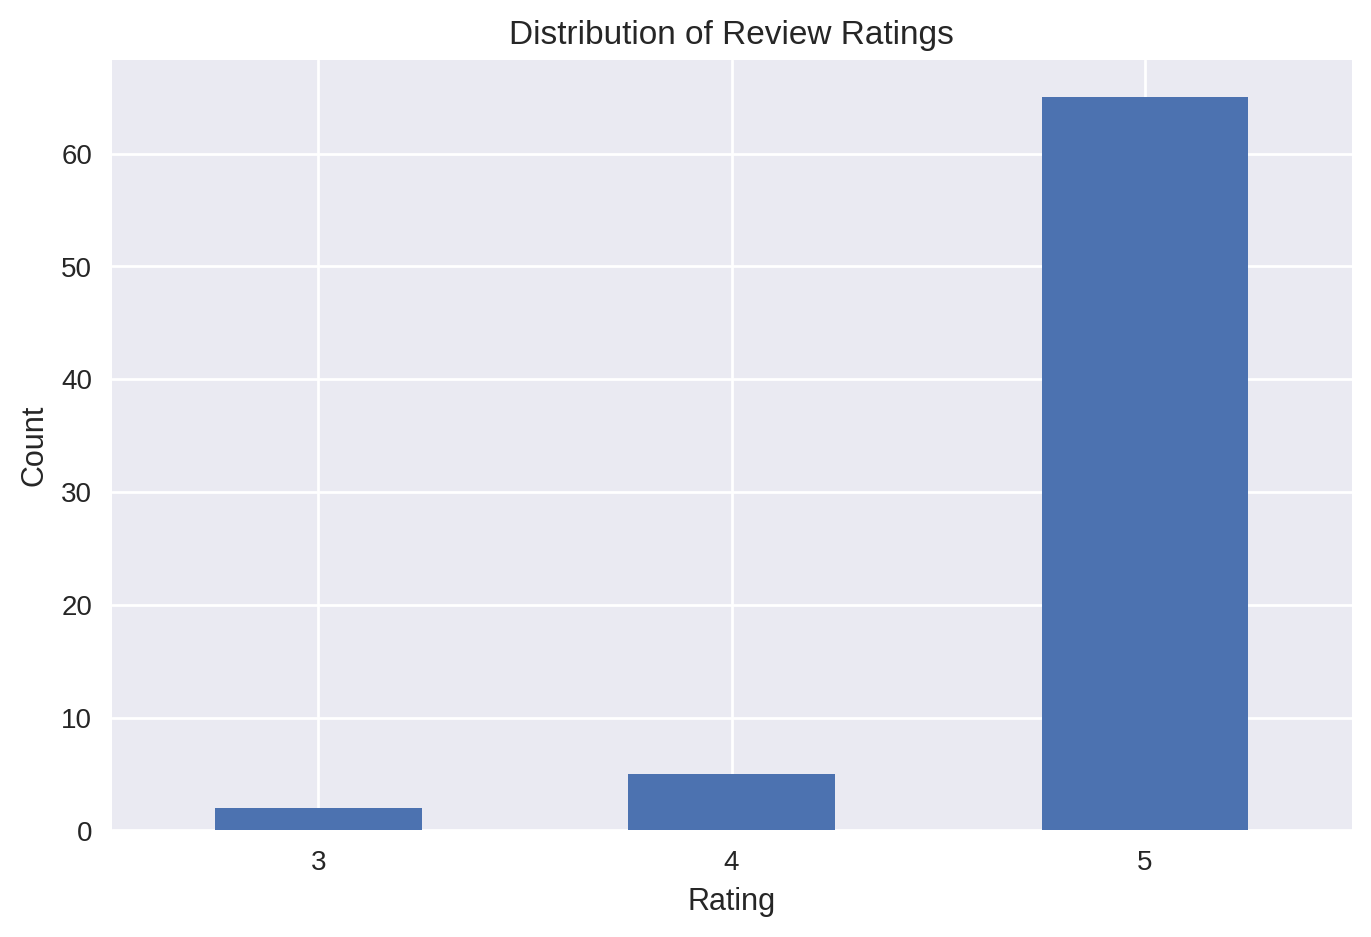

In [27]:
import matplotlib.pyplot as plt

# Plot the distribution of review ratings
plt.figure(figsize=(8, 5))
df_review_moneyspent['rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Review Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [28]:
!pip install -q transformers

In [29]:
#Creating polarity on the column: content (review from the apps) using TextBlob
#Read https://textblob.readthedocs.io/en/dev/quickstart.html

from textblob import TextBlob
df_review_moneyspent['sentiment_polarity'] = df_review_moneyspent['cleaned_review'].apply(lambda x: TextBlob(x).polarity)
df_review_moneyspent['sentiment_subjective'] = df_review_moneyspent['cleaned_review'].apply(lambda x: TextBlob(x).subjectivity)

In [30]:
df_review_moneyspent

,no,money_spent,username,umkm,review,batas_bawah,batas_atas,median,rating,cleaned_review,sentiment_polarity,sentiment_subjective
0,1,0-25000,Ilungg,Bakso Eko,tidak ada transcript,0,25000,12500,5,tidak ada transcript,0.0,0.00
1,2,0-25000,Fareldanendraa,Bakso Eko,baksonya enak,0,25000,12500,5,bakso enak,0.0,0.00
2,3,0-25000,irfanalmizan,Bakso Eko,baksonya enak abis,0,25000,12500,5,bakso enak abis,0.0,0.00
3,4,0-25000,ryanadiputrapratama,Bakso Eko,tidak ada transcript,0,25000,12500,5,tidak ada transcript,0.0,0.00
4,5,0-25000,dwmhr,Bakso Eko,baksonya sangat enak,0,25000,12500,5,bakso sangat enak,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...
67,68,0-25000,rajen270_,Bakso Pak Parlin,sangat enak,0,25000,12500,5,sangat enak,0.0,0.00
68,69,0-25000,AdityaIyan,Bebek Goreng Mesra Surabaya,"Ya disini, masih dibuatin bebeknya, kemungkinan rasanya enak ya, saya disini pesen dada, harganya 25 ribu, tempatnya sangat cozy, ada ac, ruangannya tertutup,enak lah pokoknya.",0,25000,12500,4,ya sini masih dibuatin bebek mungkin rasa enak ya saya sini sen dada harga 25 ribu tempat sangat cozy ada ac ruang tertutupenak lah pokok,-0.2,0.75
69,70,0-25000,zafira271,Bebek Goreng Mesra Surabaya,jadi di sini saya pesan bebek,0,25000,12500,5,jadi di sini saya pesan bebek,0.0,0.00
70,71,76000-100000,Sirund,Diva Cookies,pelayanan cepat dan ramah,76000,100000,88000,5,layan cepat dan ramah,0.0,0.00


In [32]:
df_review_moneyspent.to_csv('out3==3aftersentiment.csv', index=False)

In [33]:
df_review_moneyspent.loc[:,["umkm","username","cleaned_review","rating","sentiment_polarity", "sentiment_subjective"]]

,umkm,username,cleaned_review,rating,sentiment_polarity,sentiment_subjective
0,Bakso Eko,Ilungg,tidak ada transcript,5,0.0,0.00
1,Bakso Eko,Fareldanendraa,bakso enak,5,0.0,0.00
2,Bakso Eko,irfanalmizan,bakso enak abis,5,0.0,0.00
3,Bakso Eko,ryanadiputrapratama,tidak ada transcript,5,0.0,0.00
4,Bakso Eko,dwmhr,bakso sangat enak,5,0.0,0.00
...,...,...,...,...,...,...
67,Bakso Pak Parlin,rajen270_,sangat enak,5,0.0,0.00
68,Bebek Goreng Mesra Surabaya,AdityaIyan,ya sini masih dibuatin bebek mungkin rasa enak ya saya sini sen dada harga 25 ribu tempat sangat cozy ada ac ruang tertutupenak lah pokok,4,-0.2,0.75
69,Bebek Goreng Mesra Surabaya,zafira271,jadi di sini saya pesan bebek,5,0.0,0.00
70,Diva Cookies,Sirund,layan cepat dan ramah,5,0.0,0.00


In [34]:
# Group by 'umkm_id' and calculate the mean sentiment polarity and subjectivity
grouped_sentiment_by_umkm = df_review_moneyspent.groupby('umkm')[['sentiment_polarity', 'sentiment_subjective']].mean()

# Instead of using ace_tools, use the following to display the DataFrame:
print("Average Sentiment by UMKM:")
print(grouped_sentiment_by_umkm)

# Or, for a more interactive display in a Jupyter Notebook:
display(grouped_sentiment_by_umkm)

Average Sentiment by UMKM:
                                       sentiment_polarity  \
umkm                                                        
Bakso Eko                                        0.000000   
Bakso Pak Parlin                                 0.000000   
Bebek Goreng Mesra Surabaya                     -0.066667   
Diva Cookies                                     0.000000   
Drink House                                      0.000000   
Es Coklat Mantap                                 0.000000   
Kantin Asrama Bu Geprek                          0.000000   
Kedai Minuman Asrama                             0.000000   
Kress Nyuss Fried Chicken                       -0.200000   
Mak Nun (Kafetaria Informatika)                  0.000000   
NLH Snack Ringan                                 0.000000   
Pempek Berlian                                   0.000000   
Pentol Petarung                                  0.200000   
Sambelan Cak Dayat                               0.000000 

,sentiment_polarity,sentiment_subjective
umkm,,
Bakso Eko,0.000000,0.000000
Bakso Pak Parlin,0.000000,0.000000
Bebek Goreng Mesra Surabaya,-0.066667,0.250000
Diva Cookies,0.000000,0.000000
Drink House,0.000000,0.000000
Es Coklat Mantap,0.000000,0.000000
Kantin Asrama Bu Geprek,0.000000,0.000000
Kedai Minuman Asrama,0.000000,0.000000
Kress Nyuss Fried Chicken,-0.200000,0.316667


In [35]:
# Import required library
import pandas as pd

# Ensure df_review_moneyspent exists
if 'df_review_moneyspent' in locals():
    # Group by UMKM and calculate required metrics
    grouped_df = df_review_moneyspent.groupby("umkm").agg(
        Number_of_Visits=("username", "count"),  # Count unique users as visits
        Number_of_Feedbacks=("review", "count"),  # Count total reviews
        Average_Rating=("rating", "mean"),  # Average rating
        Average_Spend=("median", "mean"),  # Average spend (median spend column)
        Sentiment=("sentiment_polarity", "mean")  # Average sentiment polarity
    ).reset_index()

    # Display the grouped data
    from IPython.display import display
    display(grouped_df)
else:
    print("The DataFrame 'df_review_moneyspent' is not found in the environment.")


,umkm,Number_of_Visits,Number_of_Feedbacks,Average_Rating,Average_Spend,Sentiment
0,Bakso Eko,11,11,4.818182,12500.0,0.000000
1,Bakso Pak Parlin,9,9,5.000000,12500.0,0.000000
2,Bebek Goreng Mesra Surabaya,3,3,4.000000,21000.0,-0.066667
3,Diva Cookies,8,8,5.000000,34562.5,0.000000
4,Drink House,14,14,4.928571,12500.0,0.000000
5,Es Coklat Mantap,2,2,5.000000,12500.0,0.000000
6,Kantin Asrama Bu Geprek,3,3,5.000000,12500.0,0.000000
7,Kedai Minuman Asrama,6,6,5.000000,12500.0,0.000000
8,Kress Nyuss Fried Chicken,3,3,4.666667,12500.0,-0.200000
9,Mak Nun (Kafetaria Informatika),2,2,5.000000,12500.0,0.000000


In [36]:
# Sort the DataFrame by 'Number_of_Visits' in descending order
grouped_df_sorted = grouped_df.sort_values(by='Number_of_Visits', ascending=False)

# Display the sorted DataFrame
display(grouped_df_sorted)


,umkm,Number_of_Visits,Number_of_Feedbacks,Average_Rating,Average_Spend,Sentiment
4,Drink House,14,14,4.928571,12500.0,0.000000
0,Bakso Eko,11,11,4.818182,12500.0,0.000000
1,Bakso Pak Parlin,9,9,5.000000,12500.0,0.000000
3,Diva Cookies,8,8,5.000000,34562.5,0.000000
7,Kedai Minuman Asrama,6,6,5.000000,12500.0,0.000000
12,Pentol Petarung,3,3,4.666667,12500.0,0.200000
2,Bebek Goreng Mesra Surabaya,3,3,4.000000,21000.0,-0.066667
6,Kantin Asrama Bu Geprek,3,3,5.000000,12500.0,0.000000
8,Kress Nyuss Fried Chicken,3,3,4.666667,12500.0,-0.200000
13,Sambelan Cak Dayat,2,2,5.000000,25250.0,0.000000


## Exploratory Data Analysis

In [37]:
df_review_moneyspent.to_csv('out4groupedbyumkmsentiment.csv', index=False)

In [38]:
# Create a mapping of unique umkm_id values to numbers 1 to 10
umkm_id_mapping = {umkm_id: idx+1 for idx, umkm_id in enumerate(df_review_moneyspent['umkm'].unique())}

# Replace umkm_id values in the dataframe with the mapped numbers
df_review_moneyspent['umkm'] = df_review_moneyspent['umkm'].map(umkm_id_mapping)

# Display the updated dataframe with numerical umkm_id
df_review_moneyspent_selected = df_review_moneyspent.loc[:, ["umkm","review","rating", "sentiment_polarity", "sentiment_subjective"]]
display(df_review_moneyspent_selected)

,umkm,review,rating,sentiment_polarity,sentiment_subjective
0,1,tidak ada transcript,5,0.0,0.00
1,1,baksonya enak,5,0.0,0.00
2,1,baksonya enak abis,5,0.0,0.00
3,1,tidak ada transcript,5,0.0,0.00
4,1,baksonya sangat enak,5,0.0,0.00
...,...,...,...,...,...
67,2,sangat enak,5,0.0,0.00
68,17,"Ya disini, masih dibuatin bebeknya, kemungkinan rasanya enak ya, saya disini pesen dada, harganya 25 ribu, tempatnya sangat cozy, ada ac, ruangannya tertutup,enak lah pokoknya.",4,-0.2,0.75
69,17,jadi di sini saya pesan bebek,5,0.0,0.00
70,12,pelayanan cepat dan ramah,5,0.0,0.00


In [39]:
# Sort the DataFrame by 'Number_of_Visits' in descending order
grouped_df_sorted = grouped_df.sort_values(by='Number_of_Visits', ascending=False)

# Display the sorted DataFrame
display(grouped_df_sorted)


,umkm,Number_of_Visits,Number_of_Feedbacks,Average_Rating,Average_Spend,Sentiment
4,Drink House,14,14,4.928571,12500.0,0.000000
0,Bakso Eko,11,11,4.818182,12500.0,0.000000
1,Bakso Pak Parlin,9,9,5.000000,12500.0,0.000000
3,Diva Cookies,8,8,5.000000,34562.5,0.000000
7,Kedai Minuman Asrama,6,6,5.000000,12500.0,0.000000
12,Pentol Petarung,3,3,4.666667,12500.0,0.200000
2,Bebek Goreng Mesra Surabaya,3,3,4.000000,21000.0,-0.066667
6,Kantin Asrama Bu Geprek,3,3,5.000000,12500.0,0.000000
8,Kress Nyuss Fried Chicken,3,3,4.666667,12500.0,-0.200000
13,Sambelan Cak Dayat,2,2,5.000000,25250.0,0.000000


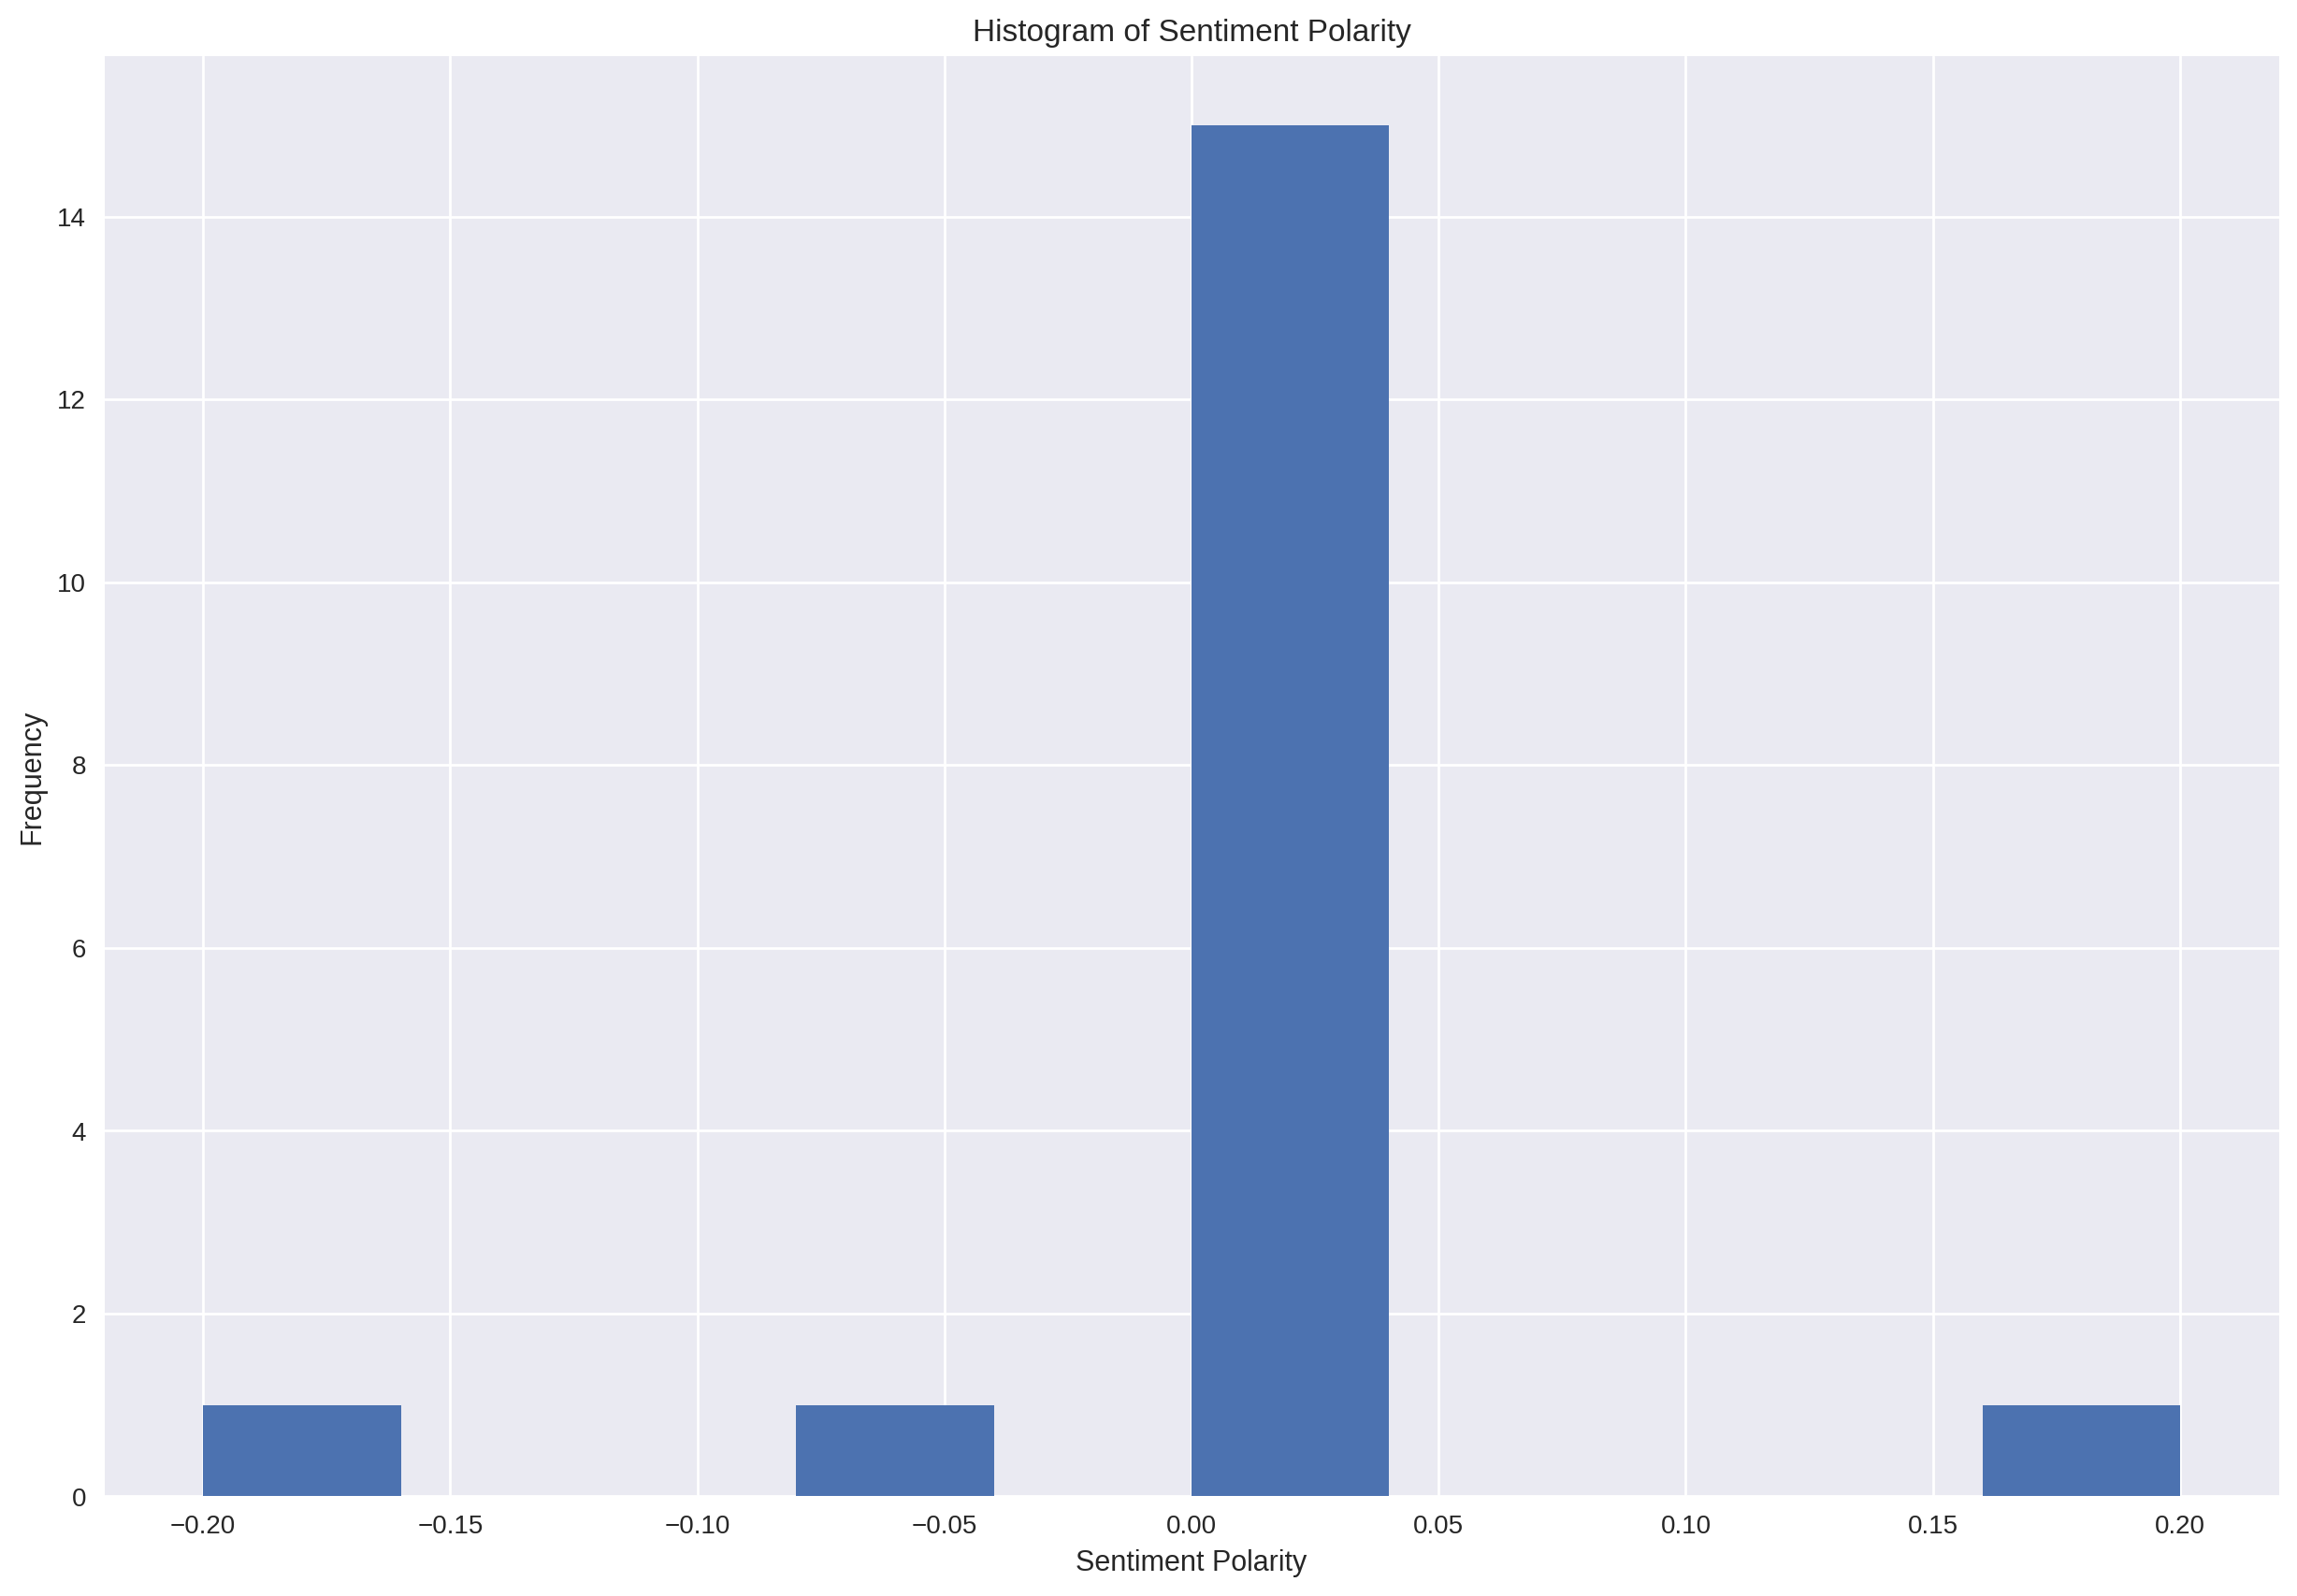

In [40]:
import matplotlib.pyplot as plt

# Create the histogram
plt.hist(grouped_sentiment_by_umkm['sentiment_polarity'], bins=10)  # Adjust the number of bins as needed

# Add labels and title
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.title('Histogram of Sentiment Polarity')

# Display the histogram
plt.show()

In [42]:
# Function to clean and count word frequency
def count_words(df_review_moneyspent_selected, column):
    all_words = []

    for text in df_review_moneyspent_selected[column].dropna():
        # Lowercase, remove special characters and tokenize
        words = re.findall(r'\b\w+\b', text.lower())
        # Remove stopwords
        filtered_words = [word for word in words if word not in stop_words]
        all_words.extend(filtered_words)

    # Count word frequency
    word_freq = Counter(all_words)

    # Convert to DataFrame for better visualization
    freq_df = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency'])
    freq_df = freq_df.sort_values(by='Frequency', ascending=False)

    return freq_df

# Get word frequency
word_freq_df = count_words(df_review_moneyspent_selected, 'user_review_with_stopwords')

In [43]:
word_freq_df

,Word,Frequency
1,enak,38
21,murah,8
2,mantap,7
35,makanannya,7
0,baksonya,6
...,...,...
51,foto,1
50,sesuai,1
49,keren,1
48,oke,1


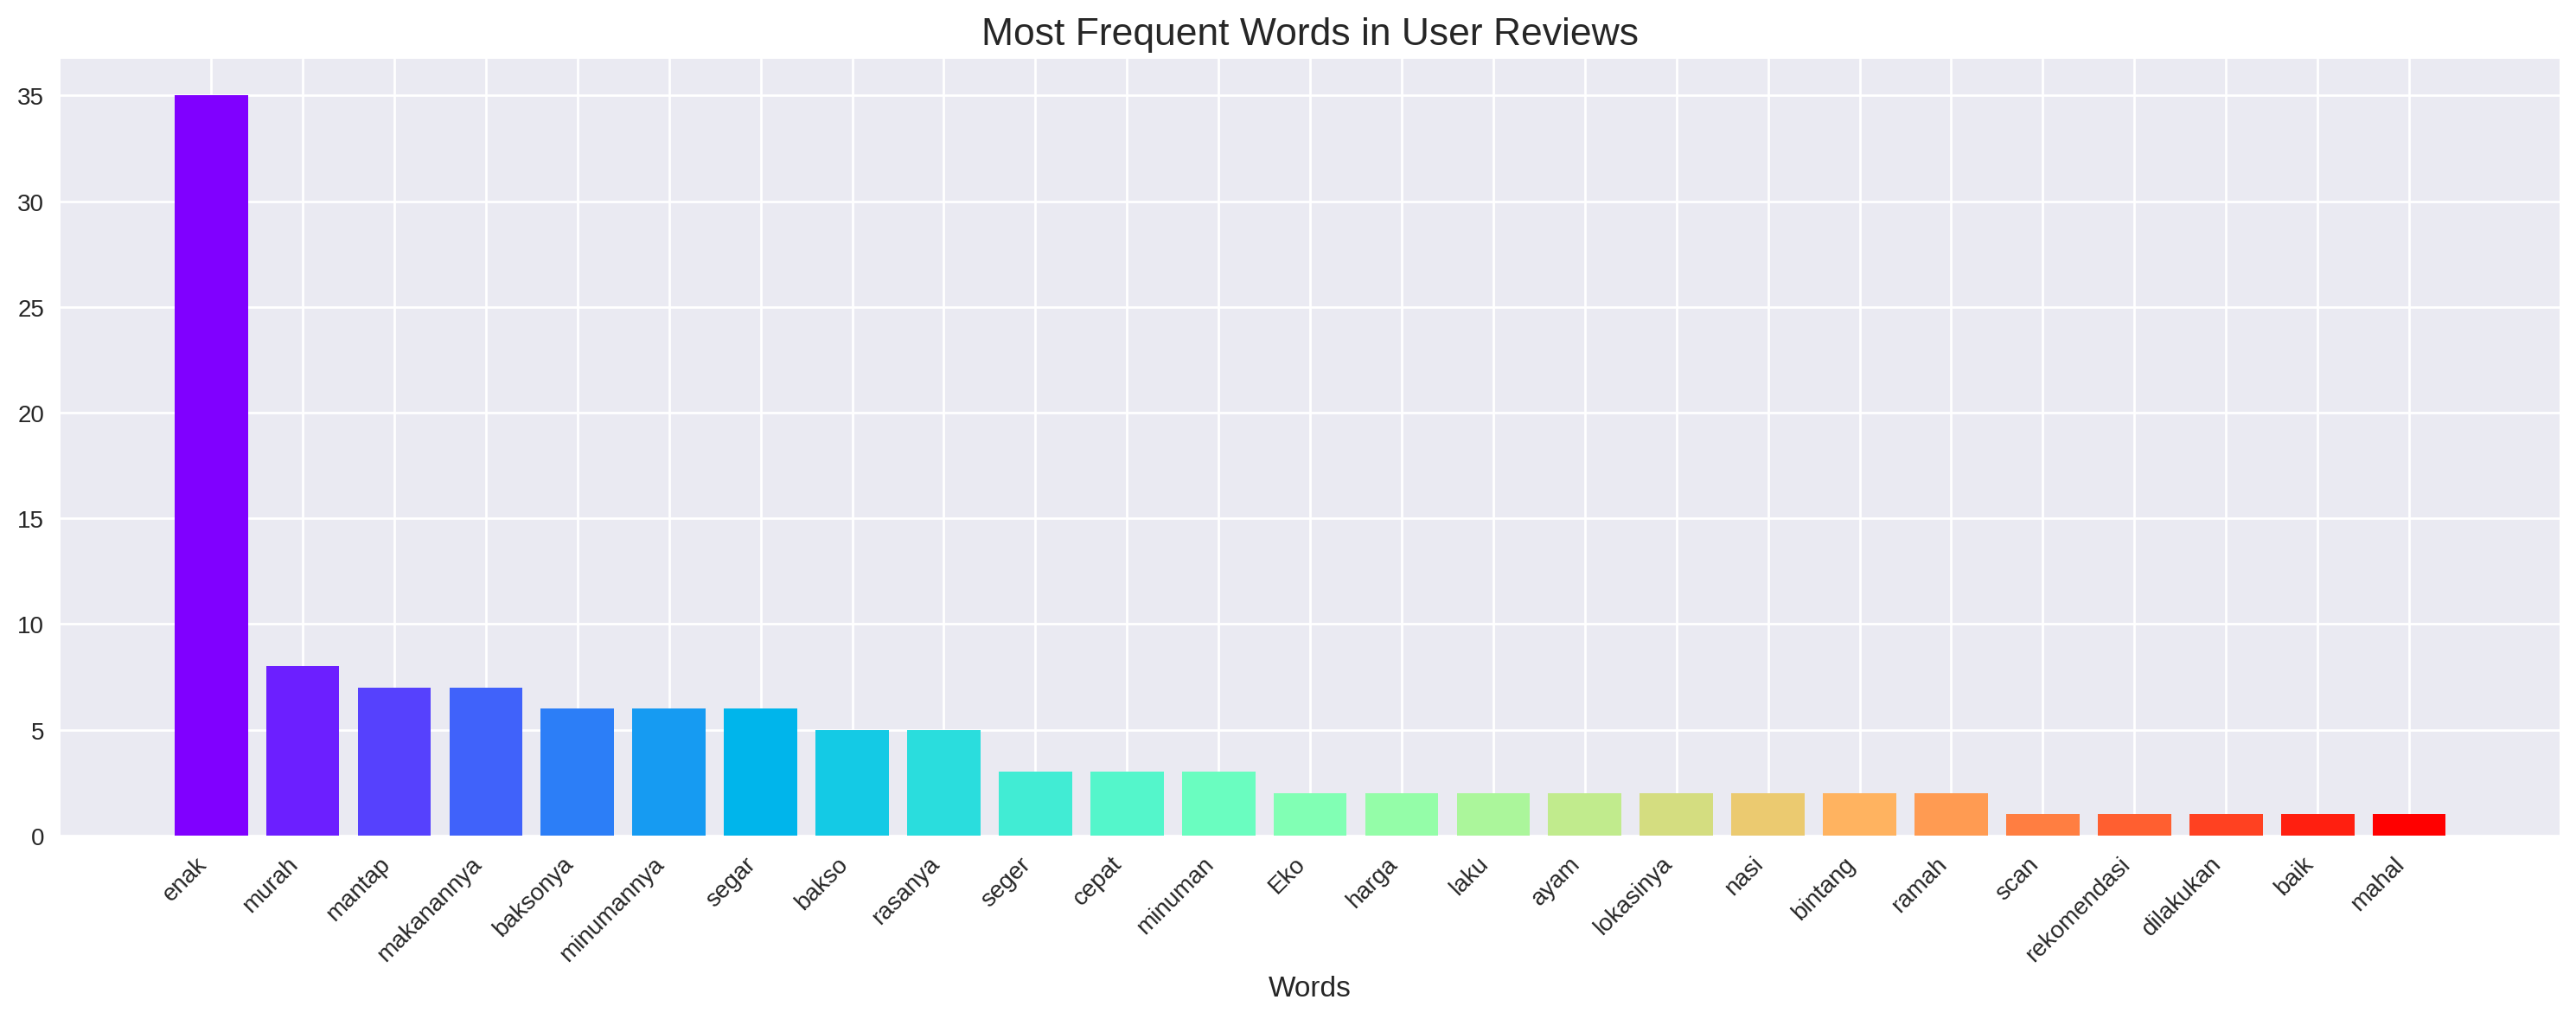

In [44]:
# Combine all reviews into a single string
all_reviews = ' '.join(df_review_moneyspent_selected['user_review_with_stopwords'])

# Tokenize the text and count word frequencies
word_counts = Counter(all_reviews.split())

# Get the most frequent words
most_common_words = word_counts.most_common(25)  # Adjust the number as needed

# Create a list of words and their frequencies
words, frequencies = zip(*most_common_words)

# Generate rainbow colors
colors = plt.cm.rainbow(np.linspace(0, 1, len(words)))

# Create the histogram
plt.figure(figsize=(15, 6))
plt.bar(words, frequencies, color=colors)
plt.title("Most Frequent Words in User Reviews", fontsize=16)
plt.xlabel("Words", fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent labels from overlapping

## Evaluation

In [45]:
#Add a column name polarity_rating from changing the score of the review into 3 labels: Pos, Negative Neutral
df_review_moneyspent_selected['sentiment_rating'] = df_review_moneyspent_selected['rating'].apply(lambda x: 'Positive' if x > 3 else('Neutral' if x == 3  else 'Negative'))

In [46]:
#Add a column name polarity_rating from changing the score of the review into 3 labels: Pos, Negative Neutral
df_review_moneyspent_selected['sentiment_rating'] = df_review_moneyspent_selected['rating'].apply(lambda x: 'Positive' if x > 3 else('Neutral' if x == 3  else 'Negative'))

# Access the desired columns
df_review_moneyspent_selected.loc[:,["umkm","review","rating", "sentiment_polarity", "sentiment_subjective","sentiment_rating"]] #This line was changed to fix the error.

,umkm,review,rating,sentiment_polarity,sentiment_subjective,sentiment_rating
0,1,tidak ada transcript,5,0.0,0.00,Positive
1,1,baksonya enak,5,0.0,0.00,Positive
2,1,baksonya enak abis,5,0.0,0.00,Positive
3,1,tidak ada transcript,5,0.0,0.00,Positive
4,1,baksonya sangat enak,5,0.0,0.00,Positive
...,...,...,...,...,...,...
67,2,sangat enak,5,0.0,0.00,Positive
68,17,"Ya disini, masih dibuatin bebeknya, kemungkinan rasanya enak ya, saya disini pesen dada, harganya 25 ribu, tempatnya sangat cozy, ada ac, ruangannya tertutup,enak lah pokoknya.",4,-0.2,0.75,Positive
69,17,jadi di sini saya pesan bebek,5,0.0,0.00,Positive
70,12,pelayanan cepat dan ramah,5,0.0,0.00,Positive


In [47]:
df_review_moneyspent_selected = df_review_moneyspent.loc[:, ["umkm","username","review","rating", "sentiment_polarity", "sentiment_subjective"]]
df_review_moneyspent_selected['username'] = df_review_moneyspent['username']

In [48]:
print(df_review_moneyspent_selected.umkm.unique())
print("Lapak yang dilakukan review ada sebanyak: ", df_review_moneyspent_selected.umkm.nunique())
print("User yang melakukan review ada sebanyak: ", df_review_moneyspent_selected.username.nunique())

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18]
Lapak yang dilakukan review ada sebanyak:  18
User yang melakukan review ada sebanyak:  49


In [49]:
# Group by 'umkm_id' and calculate the mean sentiment polarity and subjectivity
grouped_sentiment_by_umkm = df_review_moneyspent_selected.groupby('umkm')[['sentiment_polarity', 'sentiment_subjective']].mean()

In [50]:
df = df_review_moneyspent_selected

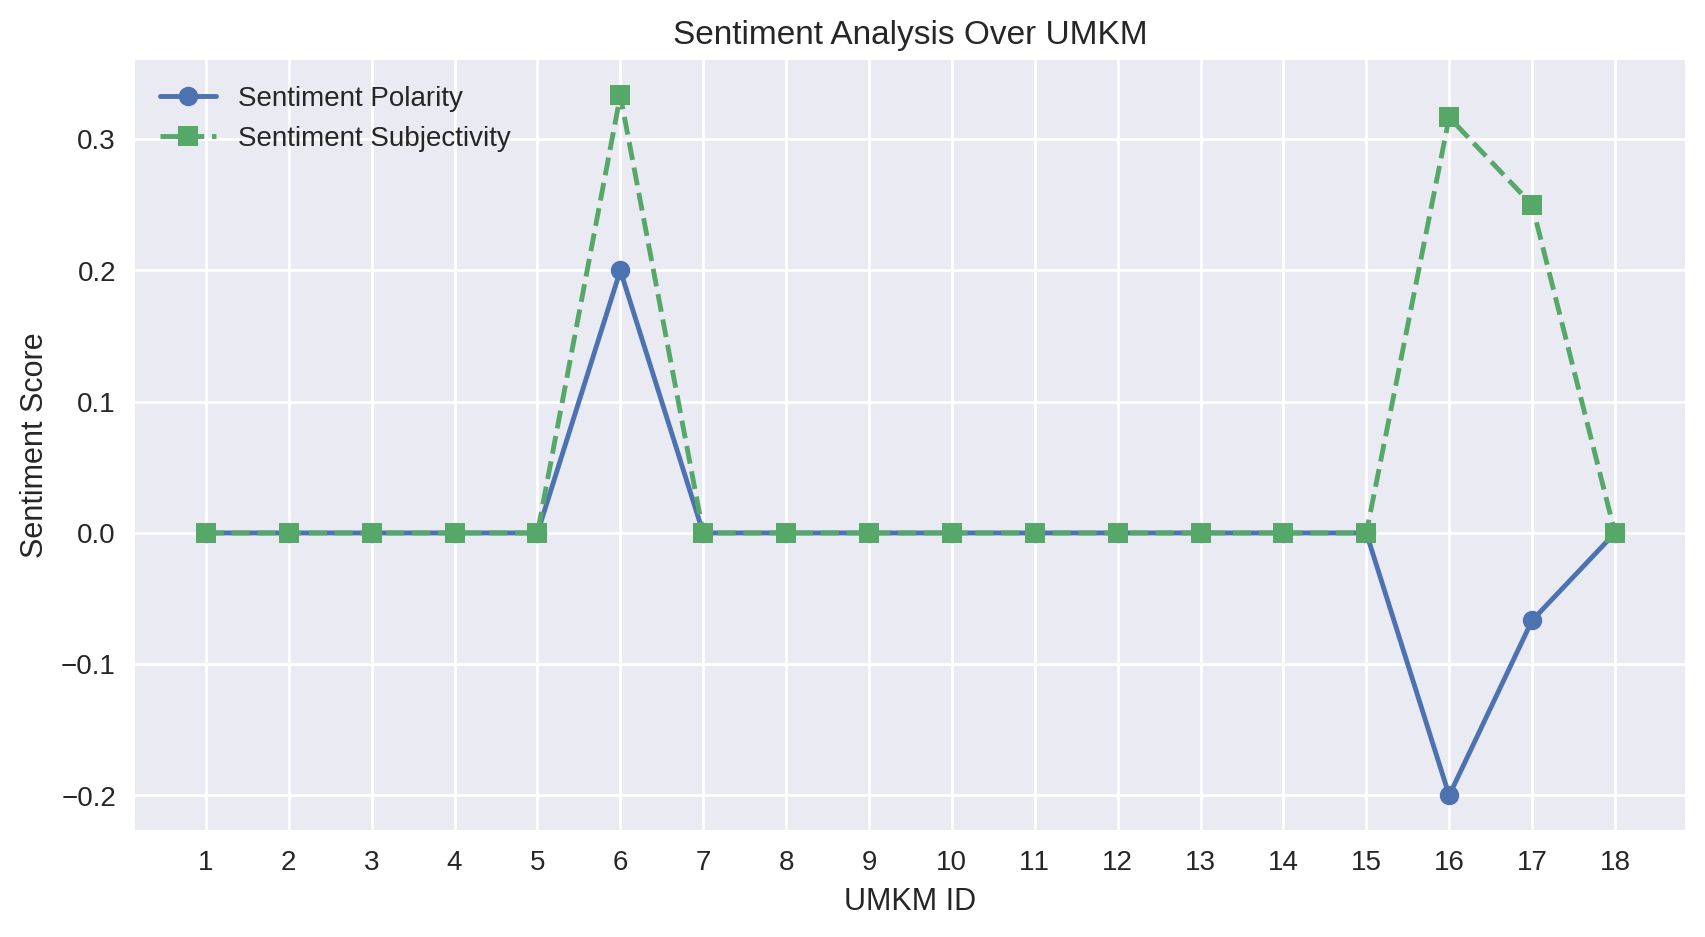

In [51]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame (replace this with actual DataFrame)
data = grouped_sentiment_by_umkm

df = pd.DataFrame(data)

# Reset the index to make 'umkm' a column
df = df.reset_index() #This line was added to fix the error.

# Create a line chart
plt.figure(figsize=(10, 5))
plt.plot(df["umkm"], df["sentiment_polarity"], marker="o", linestyle="-", label="Sentiment Polarity")
plt.plot(df["umkm"], df["sentiment_subjective"], marker="s", linestyle="--", label="Sentiment Subjectivity")

# Labels and title
plt.xlabel("UMKM ID")
plt.ylabel("Sentiment Score")
plt.title("Sentiment Analysis Over UMKM")
plt.legend()
plt.grid(True)

# Ensure x-axis displays each UMKM ID
plt.xticks(df["umkm"])

# Show the plot
plt.show()

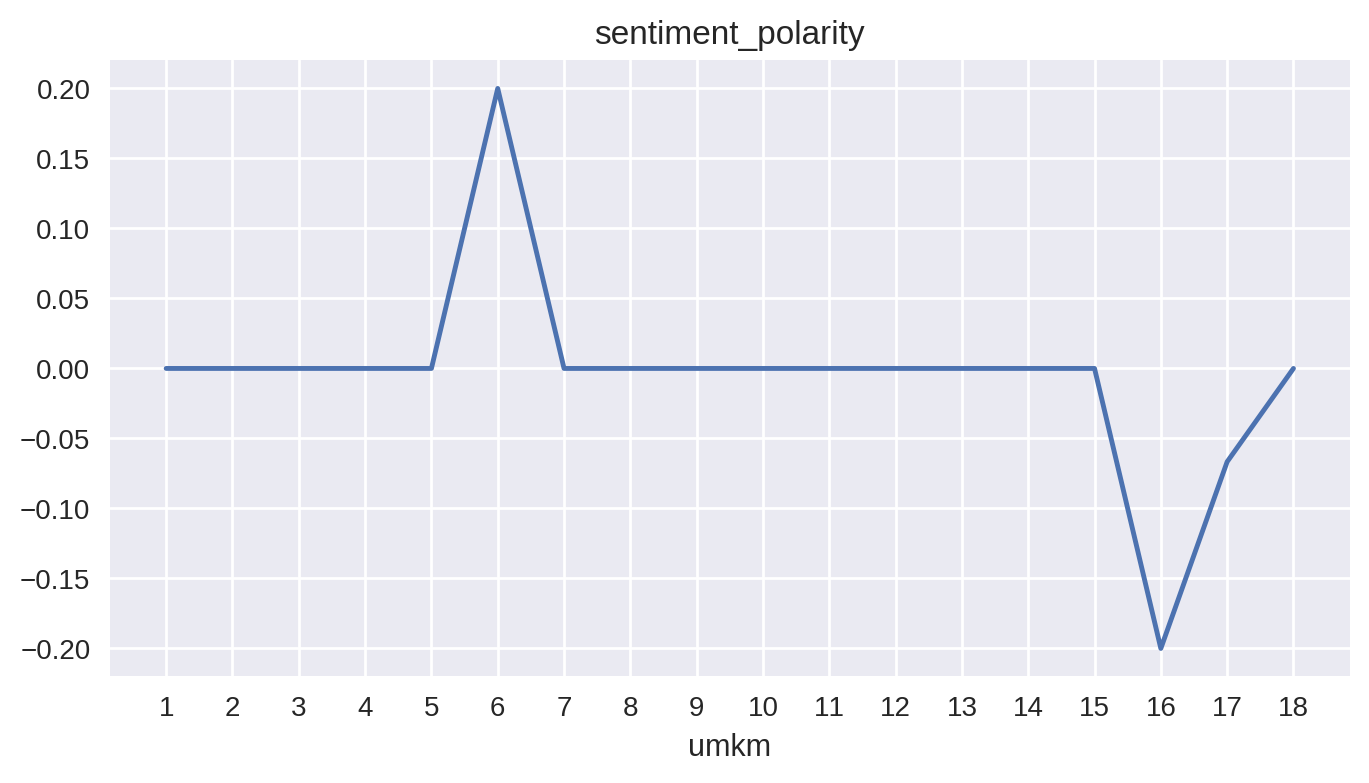

In [52]:
from matplotlib import pyplot as plt
grouped_sentiment_by_umkm['sentiment_polarity'].plot(kind='line', figsize=(8, 4), title='sentiment_polarity')

# Ensure x-axis displays each UMKM ID
plt.xticks(df["umkm"])

plt.gca().spines[['top', 'right']].set_visible(False)

<Figure size 1500x1000 with 0 Axes>

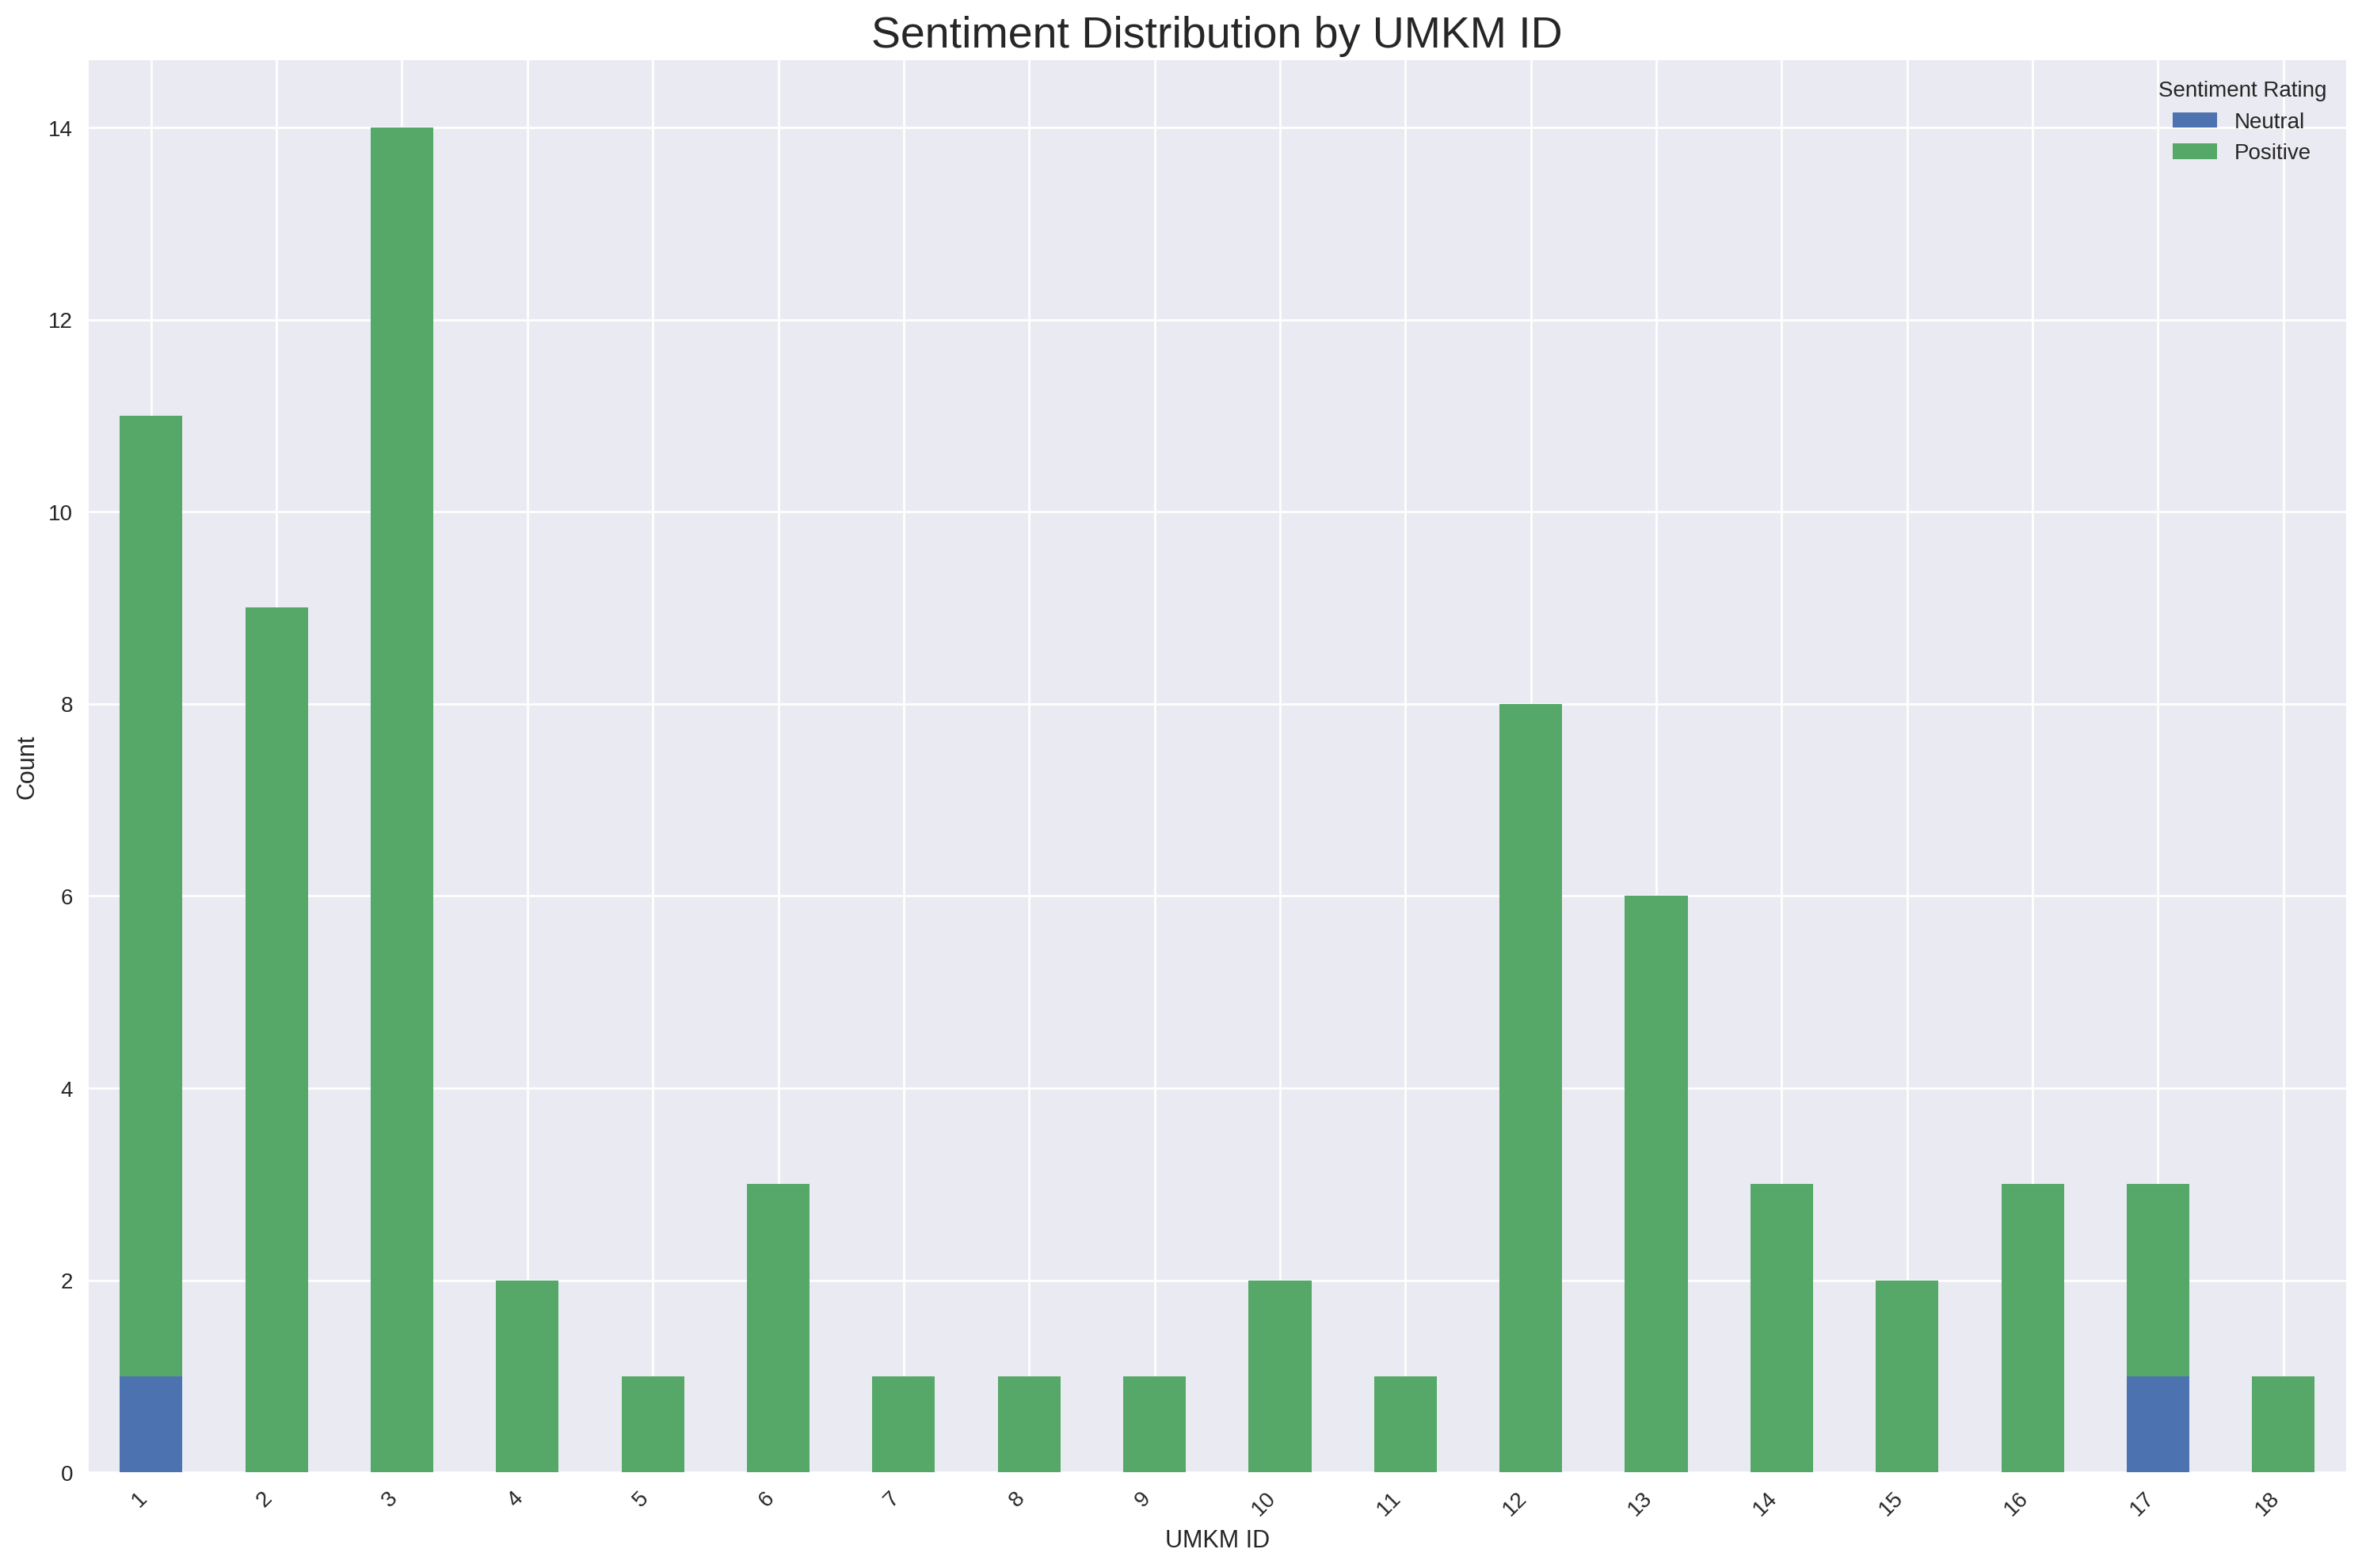

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df_review_moneyspent_selected is your DataFrame

# Add the 'sentiment_rating' column to df_review_moneyspent_selected
df_review_moneyspent_selected['sentiment_rating'] = df_review_moneyspent_selected['rating'].apply(lambda x: 'Positive' if x > 3 else ('Neutral' if x == 3 else 'Negative'))

# Group by umkm_id and sentiment_rating and count occurrences
sentiment_counts = df_review_moneyspent_selected.groupby(['umkm', 'sentiment_rating'])['sentiment_rating'].count().reset_index(name='count')

# Pivot the table to have sentiment_rating as columns
sentiment_counts_pivot = sentiment_counts.pivot(index='umkm', columns='sentiment_rating', values='count').fillna(0)

# Plot the data
plt.figure(figsize=(15, 10))
sentiment_counts_pivot.plot(kind='bar', stacked=True)  # Adjust colors as desired
plt.title("Sentiment Distribution by UMKM ID", fontsize=20)
plt.xlabel("UMKM ID")
plt.ylabel("Count")
plt.legend(title="Sentiment Rating")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels if needed
plt.tight_layout()  # Adjust layout for better spacing
plt.show()

In [55]:
# Count the number of tokens/words in the "cleaned_review" column
df_review_moneyspent["word_count"] = df_review_moneyspent["review"].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)

# Calculate total word count
total_words = df_review_moneyspent["word_count"].sum()

# Display results
total_words


403

## BERT POS Tagger

In [56]:
!pip install torch pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 53.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [58]:
!pip install huggingface_hub
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: read).
The token `indobert` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when p

In [61]:
import pandas as pd
from transformers import AutoModelForTokenClassification, AutoTokenizer, pipeline

# Load dataset
df = df_review_moneyspent

# Load the pre-trained Indonesian BERT model for POS tagging
model_name = "indobenchmark/indobert-base-p2"  #This line was added to fix the error and replace the unavailable model with a similar model that is available.

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

# Initialize the pipeline for POS tagging
pos_tagger = pipeline("ner", model=model, tokenizer=tokenizer)

# Function to perform POS tagging
def pos_tag_text(text):
    if pd.isna(text) or text.strip() == "":
        return []
    tokens = pos_tagger(text)
    return [(token['word'], token['entity']) for token in tokens]

# Apply POS tagging to the "cleaned_review" column
df["pos_tags"] = df["cleaned_review"].apply(pos_tag_text)

# Save the results
df.to_csv("pos_tagged_reviews.csv", index=False)
print("POS tagging completed. File saved as pos_tagged_reviews.csv")

# Display the first few results
df.head()

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

POS tagging completed. File saved as pos_tagged_reviews.csv


,no,money_spent,username,umkm,review,batas_bawah,batas_atas,median,rating,cleaned_review,sentiment_polarity,sentiment_subjective,word_count,pos_tags
0,1,0-25000,Ilungg,1,tidak ada transcript,0,25000,12500,5,tidak ada transcript,0.0,0.0,3,"[(tidak, LABEL_2), (ada, LABEL_4), (trans, LABEL_2), (##cript, LABEL_4)]"
1,2,0-25000,Fareldanendraa,1,baksonya enak,0,25000,12500,5,bakso enak,0.0,0.0,2,"[(bakso, LABEL_4), (enak, LABEL_4)]"
2,3,0-25000,irfanalmizan,1,baksonya enak abis,0,25000,12500,5,bakso enak abis,0.0,0.0,3,"[(bakso, LABEL_4), (enak, LABEL_4), (abis, LABEL_4)]"
3,4,0-25000,ryanadiputrapratama,1,tidak ada transcript,0,25000,12500,5,tidak ada transcript,0.0,0.0,3,"[(tidak, LABEL_2), (ada, LABEL_4), (trans, LABEL_2), (##cript, LABEL_4)]"
4,5,0-25000,dwmhr,1,baksonya sangat enak,0,25000,12500,5,bakso sangat enak,0.0,0.0,3,"[(bakso, LABEL_4), (sangat, LABEL_0), (enak, LABEL_4)]"


In [75]:
!pip install torch pandas
!pip install huggingface_hub
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    A token is already saved on your machine. Run `huggingface-cli whoami` to get more information or `huggingface-cli logout` if you want to log out.
    Setting a new token will erase the existing one.
    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: fineG

In [77]:
import pandas as pd
from transformers import AutoModelForTokenClassification, AutoTokenizer, pipeline

# Load dataset
df = df_review_moneyspent

# Load the pre-trained Indonesian Roberta model for POS tagging from a different source.
model_name = "w11wo/indonesian-roberta-base-posp-tagger"  # Replace with the valid model name

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)

# Initialize the pipeline for POS tagging
pos_tagger = pipeline("ner", model=model, tokenizer=tokenizer)

# Function to perform POS tagging
def pos_tag_text(text):
    if pd.isna(text) or text.strip() == "":
        return []
    tokens = pos_tagger(text)
    return [(token['word'], token['entity']) for token in tokens]

# Apply POS tagging to the "cleaned_review" column
df["pos_tags"] = df["cleaned_review"].apply(pos_tag_text)

# Save the results
df.to_csv("pos_tagged_reviews.csv", index=False)
print("POS tagging completed. File saved as pos_tagged_reviews.csv")

# Display the first few results
df.head()

tokenizer_config.json:   0%|          | 0.00/1.24k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/808k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/467k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.70k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

Device set to use cpu
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


POS tagging completed. File saved as pos_tagged_reviews.csv


,no,money_spent,username,umkm,review,batas_bawah,batas_atas,median,rating,cleaned_review,sentiment_polarity,sentiment_subjective,word_count,pos_tags
0,1,0-25000,Ilungg,1,tidak ada transcript,0,25000,12500,5,tidak ada transcript,0.0,0.0,3,"[(Ġtidak, B-ADV), (Ġada, B-VBE), (Ġtrans, B-NNP), (c, B-NNP), (ript, B-NNP)]"
1,2,0-25000,Fareldanendraa,1,baksonya enak,0,25000,12500,5,bakso enak,0.0,0.0,2,"[(Ġbakso, B-NNO), (Ġenak, B-NNO)]"
2,3,0-25000,irfanalmizan,1,baksonya enak abis,0,25000,12500,5,bakso enak abis,0.0,0.0,3,"[(Ġbakso, B-NNP), (Ġenak, B-NNP), (Ġabis, B-NNP)]"
3,4,0-25000,ryanadiputrapratama,1,tidak ada transcript,0,25000,12500,5,tidak ada transcript,0.0,0.0,3,"[(Ġtidak, B-ADV), (Ġada, B-VBE), (Ġtrans, B-NNP), (c, B-NNP), (ript, B-NNP)]"
4,5,0-25000,dwmhr,1,baksonya sangat enak,0,25000,12500,5,bakso sangat enak,0.0,0.0,3,"[(Ġbakso, B-NNO), (Ġsangat, B-ADV), (Ġenak, B-ADJ)]"


In [78]:
df_review_moneyspent.to_csv('review_POStag.csv', index=False)

In [79]:
df_review_moneyspent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   no                    72 non-null     int64  
 1   money_spent           72 non-null     object 
 2   username              72 non-null     object 
 3   umkm                  72 non-null     int64  
 4   review                72 non-null     object 
 5   batas_bawah           72 non-null     int64  
 6   batas_atas            72 non-null     int64  
 7   median                72 non-null     int64  
 8   rating                72 non-null     int64  
 9   cleaned_review        72 non-null     object 
 10  sentiment_polarity    72 non-null     float64
 11  sentiment_subjective  72 non-null     float64
 12  word_count            72 non-null     int64  
 13  pos_tags              72 non-null     object 
dtypes: float64(2), int64(7), object(5)
memory usage: 8.0+ KB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72 entries, 0 to 71
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   no                    72 non-null     int64  
 1   money_spent           72 non-null     object 
 2   username              72 non-null     object 
 3   umkm                  72 non-null     int64  
 4   review                72 non-null     object 
 5   batas_bawah           72 non-null     int64  
 6   batas_atas            72 non-null     int64  
 7   median                72 non-null     int64  
 8   rating                72 non-null     int64  
 9   cleaned_review        72 non-null     object 
 10  sentiment_polarity    72 non-null     float64
 11  sentiment_subjective  72 non-null     float64
 12  word_count            72 non-null     int64  
 13  pos_tags              72 non-null     object 
dtypes: float64(2), int64(7), object(5)
memory usage: 8.0+ KB


None

,no,money_spent,username,umkm,review,batas_bawah,batas_atas,median,rating,cleaned_review,sentiment_polarity,sentiment_subjective,word_count,pos_tags
0,1,0-25000,Ilungg,1,tidak ada transcript,0,25000,12500,5,tidak ada transcript,0.0,0.0,3,"[(Ġtidak, B-ADV), (Ġada, B-VBE), (Ġtrans, B-NNP), (c, B-NNP), (ript, B-NNP)]"
1,2,0-25000,Fareldanendraa,1,baksonya enak,0,25000,12500,5,bakso enak,0.0,0.0,2,"[(Ġbakso, B-NNO), (Ġenak, B-NNO)]"
2,3,0-25000,irfanalmizan,1,baksonya enak abis,0,25000,12500,5,bakso enak abis,0.0,0.0,3,"[(Ġbakso, B-NNP), (Ġenak, B-NNP), (Ġabis, B-NNP)]"
3,4,0-25000,ryanadiputrapratama,1,tidak ada transcript,0,25000,12500,5,tidak ada transcript,0.0,0.0,3,"[(Ġtidak, B-ADV), (Ġada, B-VBE), (Ġtrans, B-NNP), (c, B-NNP), (ript, B-NNP)]"
4,5,0-25000,dwmhr,1,baksonya sangat enak,0,25000,12500,5,bakso sangat enak,0.0,0.0,3,"[(Ġbakso, B-NNO), (Ġsangat, B-ADV), (Ġenak, B-ADJ)]"


Missing values:
 no                      0
money_spent             0
username                0
umkm                    0
review                  0
batas_bawah             0
batas_atas              0
median                  0
rating                  0
cleaned_review          0
sentiment_polarity      0
sentiment_subjective    0
word_count              0
pos_tags                0
dtype: int64


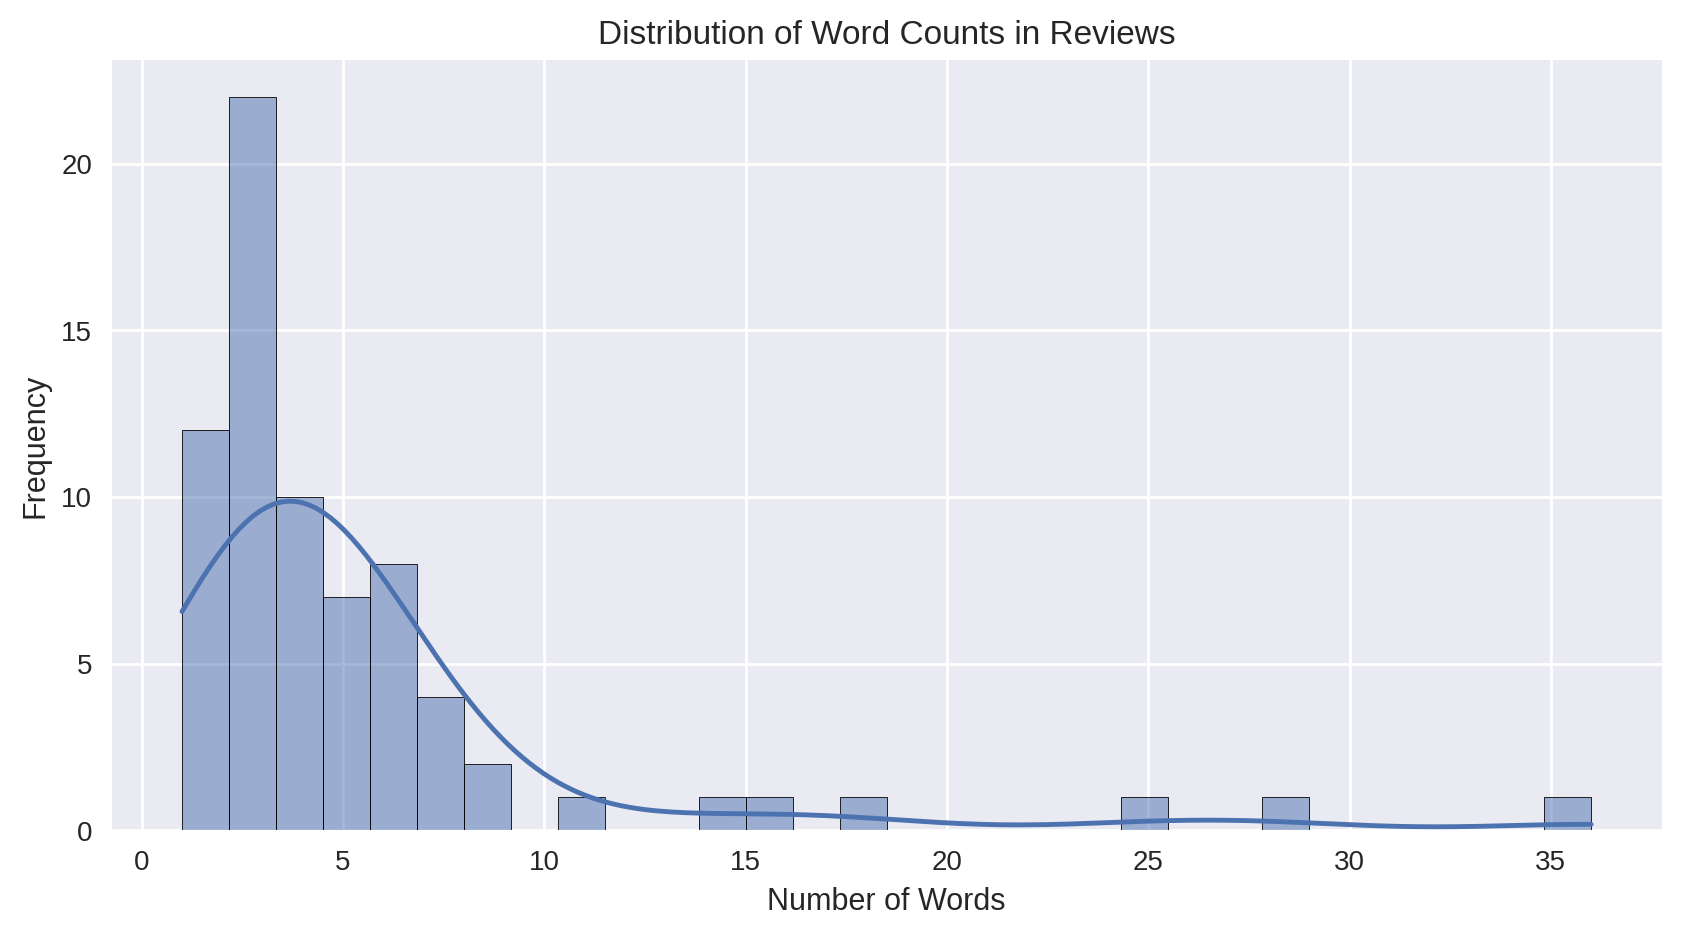

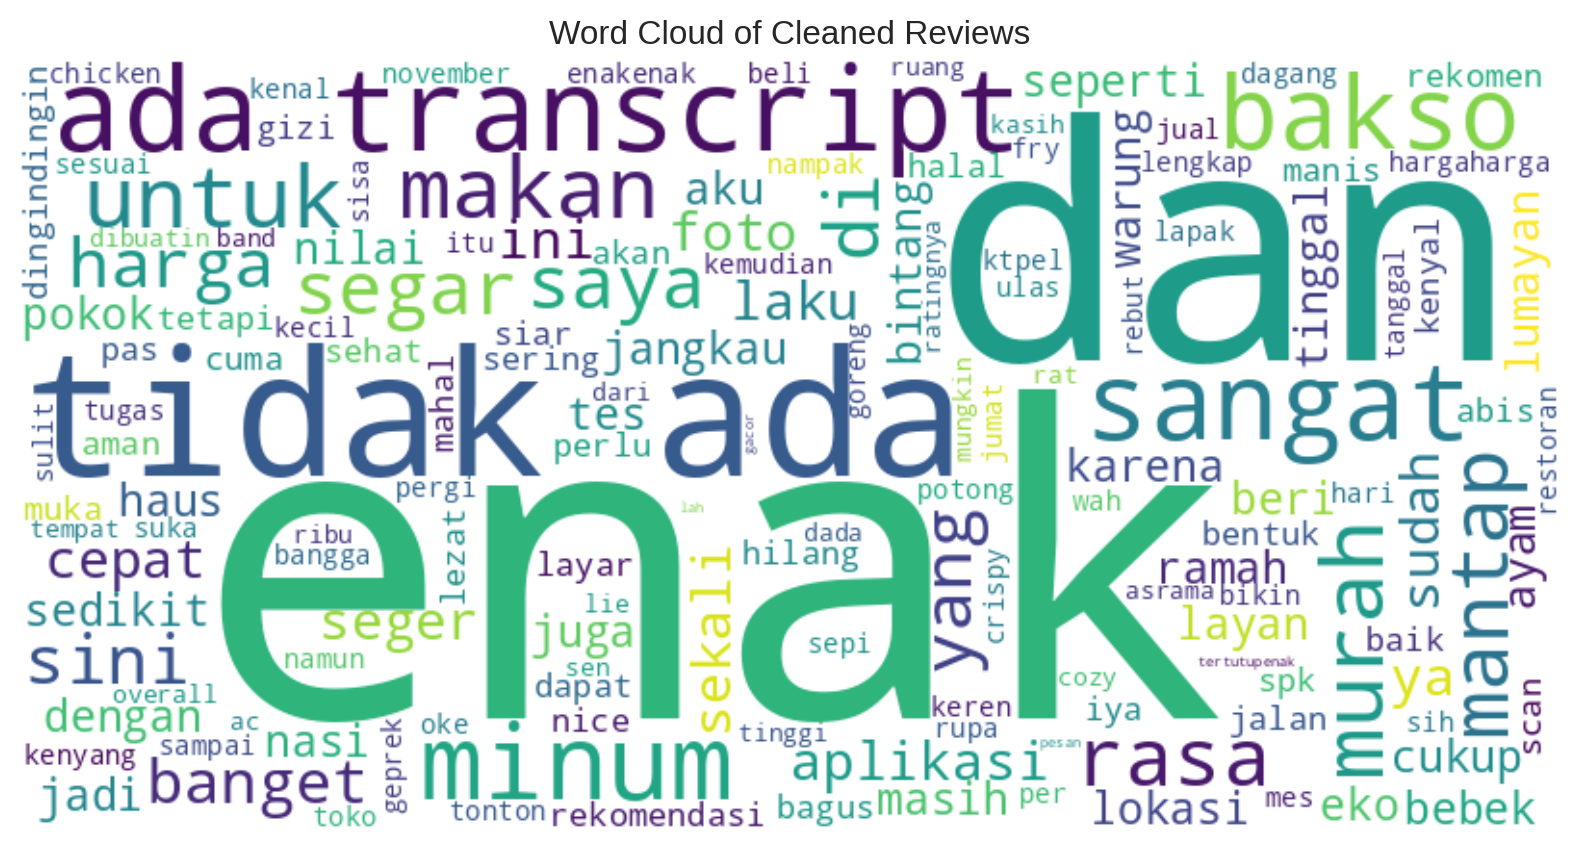

<ipython-input-81-7b40311e1333>:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=pos_df, x='POS Tag', y='Count', palette='viridis')


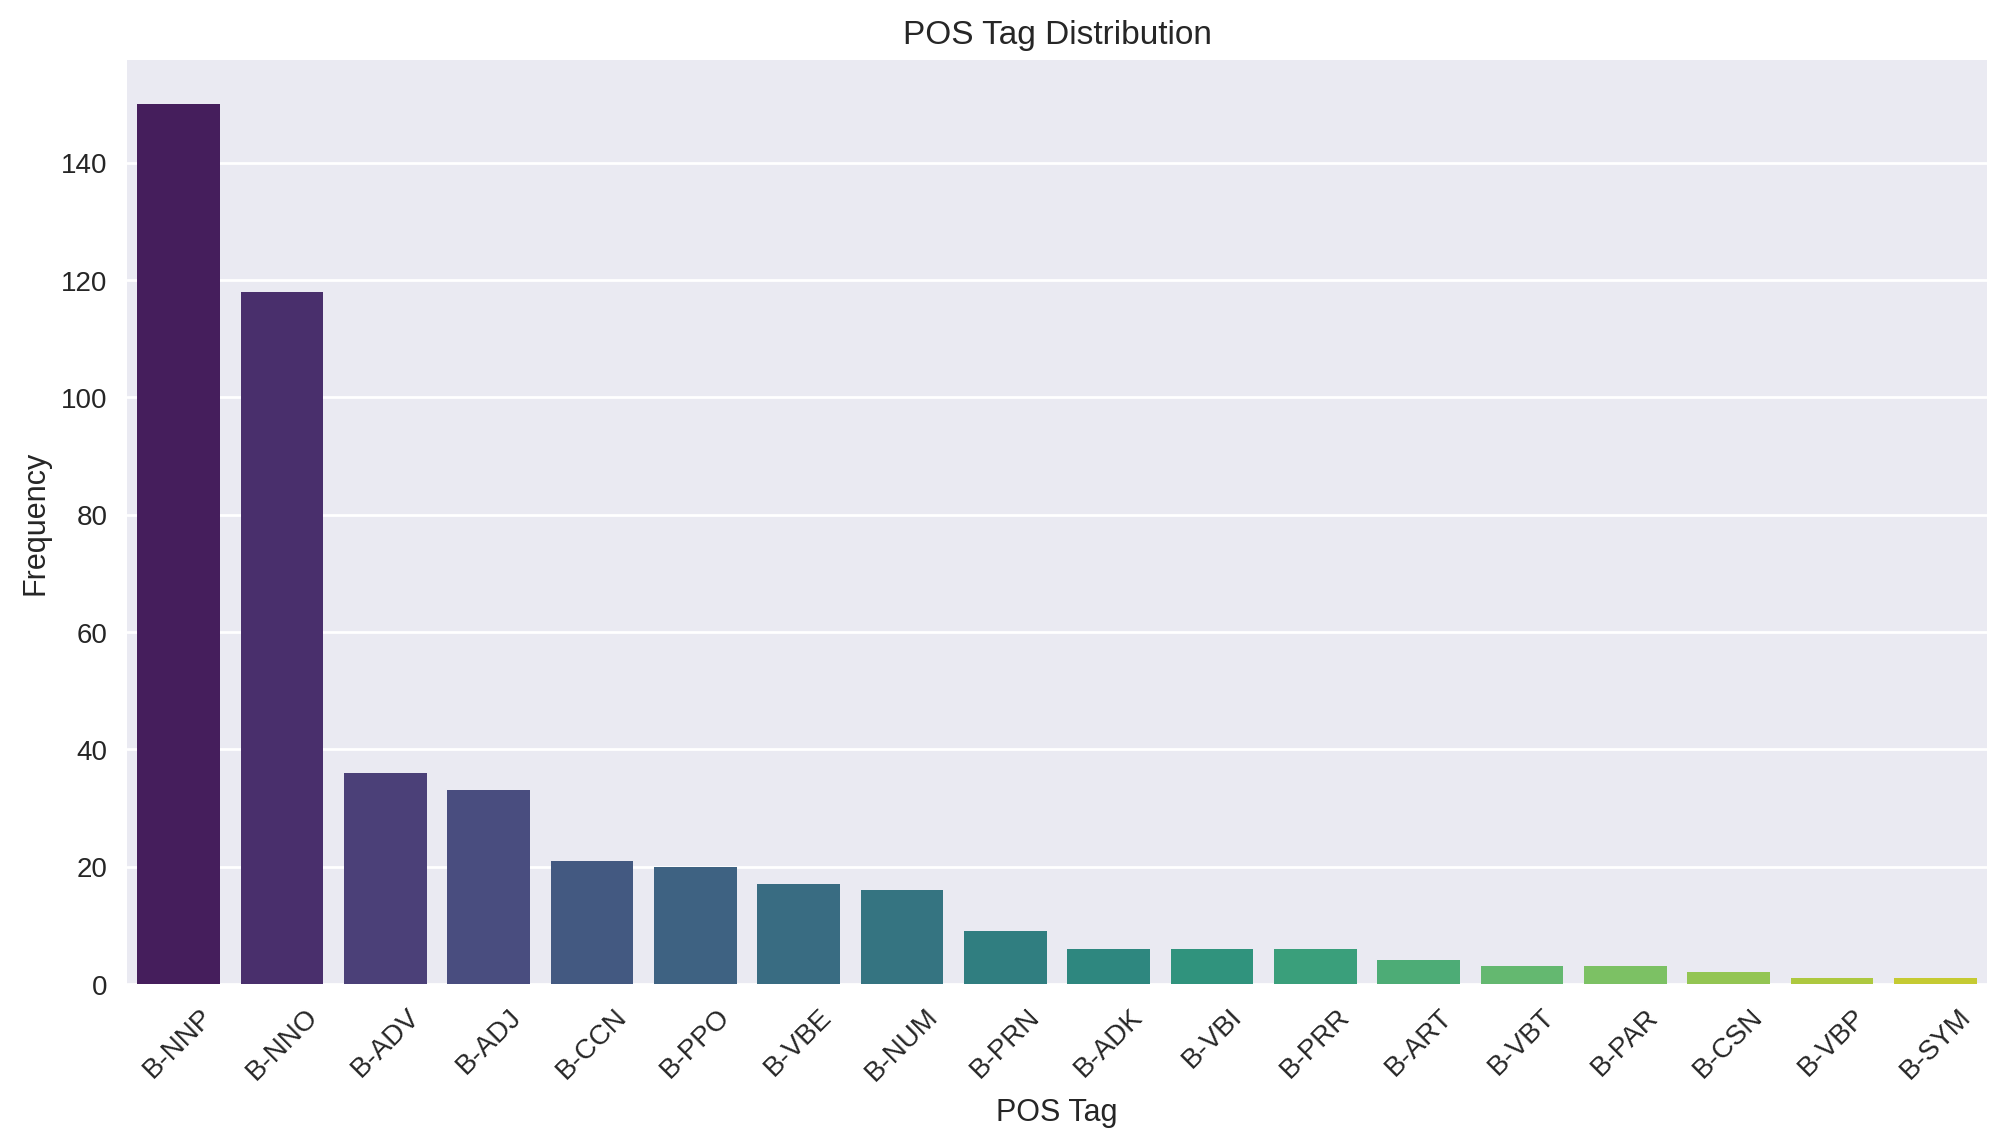

EDA Completed Successfully.


In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import ast

# Load dataset
df = df_review_moneyspent
# Convert 'pos_tags' column from string representation of list to actual list
df['pos_tags'] = df['pos_tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Display basic info
display(df.info())
display(df.head())

# Check for missing values
missing_values = df.isnull().sum()
print("Missing values:\n", missing_values)

# Word count distribution
word_counts = df['cleaned_review'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10, 5))
sns.histplot(word_counts, bins=30, kde=True)
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.title("Distribution of Word Counts in Reviews")
plt.show()

# Generate a word cloud for cleaned reviews
text = " ".join(df['cleaned_review'].dropna())
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud of Cleaned Reviews")
plt.show()

# Extract POS tags
all_pos_tags = [tag for tags in df['pos_tags'].dropna() for _, tag in tags]

# Count POS tag frequencies
pos_counts = Counter(all_pos_tags)
pos_df = pd.DataFrame(pos_counts.items(), columns=['POS Tag', 'Count']).sort_values(by='Count', ascending=False)

# Plot POS tag distribution
plt.figure(figsize=(12, 6))
sns.barplot(data=pos_df, x='POS Tag', y='Count', palette='viridis')
plt.xlabel("POS Tag")
plt.ylabel("Frequency")
plt.title("POS Tag Distribution")
plt.xticks(rotation=45)
plt.show()

print("EDA Completed Successfully.")